In [2]:
# Import Libraries
import matplotlib.pyplot as plt
from networkx import nx
import itertools
import numpy as np
import scipy as sp
from numpy.linalg import pinv
from numpy.random import randint, normal
from networkx.algorithms.clique import find_cliques, enumerate_all_cliques
from networkx.algorithms.approximation import maximum_independent_set
from networkx.algorithms.operators.unary import complement
from scipy import stats

# Block RK Functions
These are our block RK functions with different varations, but they all return the same items

In [38]:
# Standard Block RK
# x_list allows us to track evolution of x and its individual components (for "collapse" graph?)
# Takes in c: initial vector, b: Ax=b (column of zeros), A: incidence matrix, and sol: solution to Ax=b
# Also takes in list of lists (Blocks) where each block is a list of rows within the incidence matrix corresponding to
# specific subgraphs and N, number of maximum iterations
# Returns: final value of x, list of x over iterations, and error over iterations

def blockRK(A, sol, b, blocks, N, c):
    k = len(blocks)
    x = c
    x_list = [x]
    errors = []
    for j in range (1, N+1):
        i = randint(k);
        x = x + np.linalg.pinv(A[blocks[i],:])@(b[blocks[i]] - A[blocks[i],:]@x)
        errors.append(np.linalg.norm(x-sol))
        x_list.append(np.asarray(x))
    return x, x_list, errors

In [4]:
# Corrupted block RK with random link failure (RLF)
# Fails on each block randomly from a normal distribution
# Independent but not identical probability of failure
# Accepts fixed failure probability (Bernoulli)

def blockRK_RLF(A, sol, b, blocks, N, c, p=0.3):
    k = len(blocks)
    x = c
    x_list = [x]
    errors = []
    for j in range (1, N+1):
        r = stats.bernoulli.rvs(p, size = 1);
        i = randint(k)
        if r[0] == 1:
            x = x + np.linalg.pinv(A[blocks[i],:])@(b[blocks[i]] - A[blocks[i],:]@x)
        errors.append(np.linalg.norm(x-sol))
        x_list.append(x)
    return x, x_list, errors

In [5]:
# Corrupted block RK with one-off random additive noise (Gaussian)
# Adds a Gaussian noise vector to b at first

def blockRK_AGN(A, sol, b, blocks, N, c, s=0.05, m=0):
    k = len(blocks)
    x = c
    errors = []
    x_list = [x]
    err = normal(m, s, b.shape)
    b = b + err
    for j in range (1, N+1):
        x = x + np.linalg.pinv(A[blocks[i],:])@(b[blocks[i]] - A[blocks[i],:]@x) + err
    errors.append(np.linalg.norm(x-sol))
    x_list.append(x)
    return x, errors

In [6]:
# Corrupted block RK with two modes of failure: ONE-OFF additive gaussian noise and
# random link failure

def blockRK_cor(A, sol, b, blocks, N, c, p=0.3, m=0, s=0.1):
    k = len(blocks)
    x = c
    errors = []
    x_list = []
    err = normal(m, s, b.shape)
    b = b + err
    for j in range (1, N+1):
        r = stats.bernoulli.rvs(p, size = 1);
        i = randint(k)
        if r[0] == 1:
            x = x + np.linalg.pinv(A[blocks[i],:])@(b[blocks[i]] - A[blocks[i],:]@x)
            errors.append(np.linalg.norm(x-sol))
    return x, x_list, errors

# Helper Functions
These are various helper functions for use; some of them are wrapped and will not be used standalone

In [7]:
# Helper Functions for Size

# NOT TO BE USED STANDALONE
def trivial(x):
    if len(x)<=2:
        return False
    return True

In [8]:
# Helper Functions for Size

# NOT TO BE USED STANDALONE
def max_size(x, n):
    if len(x)>n:
        return False
    return True

In [9]:
# Removes all trivial subgraphs and subgraphs that are too big according to some specified maximum size
# Takes in a list of lists (list of subgraphs by nodes e.g. [1, 2] is the subgraph with the nodes 1, 2; [2, 4, 5] is the
# subgraph with nodes 2, 4 and 5)
# If no maximum size is given, only removes trivial cliques

def remove_trivial_subgraphs(sgs, n=0):
    fil_sg = list(filter(trivial, sgs))
    if n == 0:
        return fil_sg
    else:
        fil_sg = list(filter(max_size, fill_sg))
        return fil_sg

In [10]:
# Helper functions for grabbing row indices for subgraphs

# Converts sets of edges into row indices in the incidence matrix
def find_subgraph_from_edges(A,edges):
    edge_indices = []
    for edge in edges:
        for i in range(A.shape[0]):
            if A[i,edge[0]] != 0 and A[i,edge[1]] != 0:
                edge_indices.append(i)
    if len(edges) != len(edge_indices):
        print("Did not find all edges of subgraph in incidence matrix.")
    return edge_indices

In [11]:
# Helper functions for grabbing row indices for subgraphs

# need to turn list of pnts into edges
# use this for enumerate_all_cliques!
def find_subgraph_from_pnts(A,pnts):
    edge_indices = []
    for j in range(len(pnts)-1):
        for i in range(A.shape[0]):
            if A[i, pnts[j]] != 0 and A[i, pnts[j+1]]:
                edge_indices.append(i)
            if A[i, pnts[0]] != 0 and A[i, pnts[len(pnts)-1]] !=0:
                if i not in edge_indices:
                    edge_indices.append(i)
    if (len(pnts)) != len(edge_indices):
        print("Did not find all edges of subgraph in incidence matrix.")
    return edge_indices

In [12]:
# Given a list of points, grabs blocks and makes a list

def blocks_pnts(A, subgraphs):
    blocks = []
    for subgraph in subgraphs:
        blocks.append(find_subgraph_from_pnts(A, subgraph))
    return blocks

## Graphing Helper Functions
These graph the output of a specific Block RK function

In [69]:
# n is number of nodes in graph! 

def collapse_plt(x_list, n, N):
    for i in range (N):
        x_list[i] = np.concatenate(x_list[i])
    for i in range (n):
        plt.plot(range(N+1), [test_iter[f][i] for f in range(N+1)])

In [14]:
def error_plt(errors):
    plt.semilogy(range(np.shape(errors)[0]),errors)

## Conditioning Specific Helper Functions
These wrap the above functions and apply them to specific conditions: e.g. cliques

In [15]:
# Grabs subgraphs that correspond to cliques within a graph
# Input: Incidence matrix, graph

def blocks_from_cliques(G, A):
    cliques = list(enumerate_all_cliques(G))
    fill_cliques = remove_trivial_subgraphs(cliques)
    blks = blocks_pnts(A, fill_cliques)
    return blks

# Experiments
Run all experiments here

### Graph and Problem Set-Up

In [16]:
# Initialize Graph
n = 10
m = 20

G = nx.gnm_random_graph(n,m)

#Get incidence matrix
A = nx.linalg.graphmatrix.incidence_matrix(G)
A = sp.sparse.csr_matrix.todense(A).transpose()

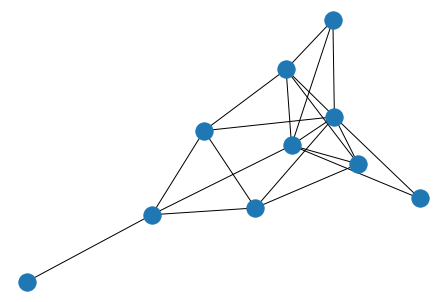

In [17]:
# Draw graph
nx.draw(G)
plt.show()

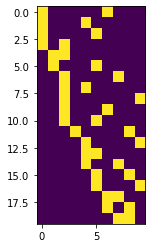

In [18]:
# Initialize Incidence Matrix
A = nx.linalg.graphmatrix.incidence_matrix(G)
A = sp.sparse.csr_matrix.todense(A).transpose()
plt.imshow(A)  # their incidence matrix is binary, we need to convert one of the ones to a -1

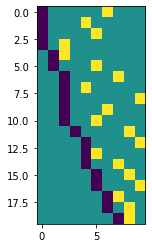

In [19]:
for i in range(np.shape(A)[0]):
    negindex = np.where(A[i,:] == 1)
    A[i,negindex[1][0]] = -1
plt.imshow(A)

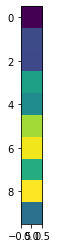

In [20]:
# Fix x, b
# Secret initial vector x
x = np.random.rand(n,1)
plt.imshow(x)
# Zero Vector b
b = np.zeros((m,1))

In [21]:
# Find mean of x
xbar = np.mean(x)
# Create solution vector (vector with just xbar as values)
sol = np.full((n,1), xbar)
sol

array([[0.60188949],
       [0.60188949],
       [0.60188949],
       [0.60188949],
       [0.60188949],
       [0.60188949],
       [0.60188949],
       [0.60188949],
       [0.60188949],
       [0.60188949]])

## Testing

In [22]:
# Grab Cliques
cliques = blocks_from_cliques(G,A)
cliques

[[1, 3, 7],
 [2, 3, 10],
 [0, 3, 9],
 [1, 2, 13],
 [4, 5, 10],
 [7, 10, 13],
 [6, 7, 14],
 [7, 8, 12],
 [8, 10, 16],
 [6, 9, 17],
 [12, 13, 16],
 [17, 18, 19],
 [2, 3, 7, 13],
 [7, 8, 13, 16]]

In [78]:
test_x, test_iter, test_errs = blockRK(A, sol, b, cliques, 150, x)

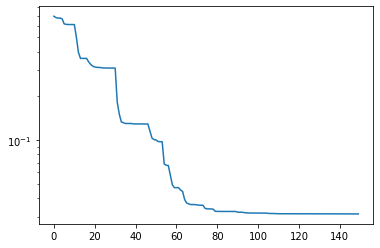

In [79]:
error_plt(test_errs)

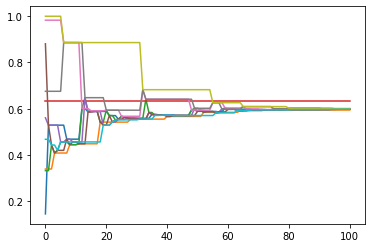

In [80]:
collapse_plt(test_iter, n, 100)

# Debugging Corner
Where bad code goes to die

In [48]:
for i in range (n):
    print(range(np.shape(pls)[0]), pls[i,:])

[array([0.1462053 , 0.3401473 , 0.33307706, 0.6316088 , 0.56113444,
        0.8806873 , 0.9825548 , 0.67558337, 0.99957913, 0.46831739]),
 array([0.1462053 , 0.3401473 , 0.33307706, 0.6316088 , 0.63671304,
        0.63671304, 0.9825548 , 0.67558337, 0.99957913, 0.63671304]),
 array([0.1462053 , 0.3401473 , 0.56080405, 0.6316088 , 0.56080405,
        0.56080405, 0.9825548 , 0.67558337, 0.99957913, 0.56080405]),
 array([0.42260447, 0.3401473 , 0.56080405, 0.6316088 , 0.42260447,
        0.42260447, 0.9825548 , 0.67558337, 0.99957913, 0.56080405]),
 array([0.46867099, 0.3401473 , 0.46867099, 0.6316088 , 0.46867099,
        0.42260447, 0.9825548 , 0.67558337, 0.99957913, 0.56080405]),
 array([0.46867099, 0.3401473 , 0.4840265 , 0.6316088 , 0.46867099,
        0.4840265 , 0.9825548 , 0.67558337, 0.99957913, 0.4840265 ]),
 array([0.4737895 , 0.3401473 , 0.4737895 , 0.6316088 , 0.4737895 ,
        0.4840265 , 0.9825548 , 0.67558337, 0.99957913, 0.4840265 ]),
 array([0.4737895 , 0.3401473 , 0.

In [54]:
test_iter=np.asmatrix(test_iter)
test_iter

ValueError: could not broadcast input array from shape (10,1) into shape (10)

In [81]:
for i in range (10):
    print(range(151), [test_iter[f][i] for f in range(151)])

range(0, 151) [0.14620530431757872, 0.5293423475225101, 0.5293423475225101, 0.5293423475225101, 0.5293423475225101, 0.5293423475225101, 0.5293423475225101, 0.46892666939161026, 0.46892666939161026, 0.46892666939161026, 0.46892666939161026, 0.46892666939161026, 0.6012578990974343, 0.6012578990974343, 0.5865619295923751, 0.5914605860940615, 0.5898277005934993, 0.5887391102597912, 0.5887391102597912, 0.5887391102597912, 0.5887391102597912, 0.5707062064859376, 0.5707062064859376, 0.5707062064859376, 0.5546363262621112, 0.5677561681277629, 0.563382887505879, 0.5604673670912897, 0.5604673670912897, 0.5604673670912897, 0.5587952387004432, 0.5587952387004432, 0.5587952387004432, 0.5587952387004432, 0.5587952387004432, 0.5756779779585994, 0.5756779779585994, 0.5743771270222257, 0.5735098930646432, 0.5735098930646432, 0.5735098930646432, 0.5735098930646432, 0.5735098930646432, 0.5714230479412493, 0.5710752404206837, 0.5710752404206837, 0.5710752404206837, 0.5710269338206051, 0.5944513368666426, 

In [40]:
hell = np.concatenate(test_iter[0])
hell2 = np.concatenate(test_iter[1])

In [41]:
hell, hell2

(array([0.1462053 , 0.3401473 , 0.33307706, 0.6316088 , 0.56113444,
        0.8806873 , 0.9825548 , 0.67558337, 0.99957913, 0.46831739]),
 array([0.1462053 , 0.3401473 , 0.33307706, 0.6316088 , 0.63671304,
        0.63671304, 0.9825548 , 0.67558337, 0.99957913, 0.63671304]))

In [36]:
test_iter[0]

array([[0.1462053 ],
       [0.3401473 ],
       [0.33307706],
       [0.6316088 ],
       [0.56113444],
       [0.8806873 ],
       [0.9825548 ],
       [0.67558337],
       [0.99957913],
       [0.46831739]])

In [ ]:
uwu = np.stack((hell, hell2))
uwu

In [87]:
list(enumerate_all_cliques(G))

[[0],
 [1],
 [2],
 [3],
 [4],
 [5],
 [6],
 [7],
 [8],
 [9],
 [0, 2],
 [0, 4],
 [0, 5],
 [0, 6],
 [1, 2],
 [1, 5],
 [2, 4],
 [2, 5],
 [2, 6],
 [2, 7],
 [2, 9],
 [3, 8],
 [4, 5],
 [4, 7],
 [4, 9],
 [5, 8],
 [5, 9],
 [6, 7],
 [6, 8],
 [7, 8],
 [0, 2, 4],
 [0, 2, 5],
 [0, 2, 6],
 [0, 4, 5],
 [1, 2, 5],
 [2, 4, 5],
 [2, 4, 7],
 [2, 4, 9],
 [2, 5, 9],
 [2, 6, 7],
 [4, 5, 9],
 [6, 7, 8],
 [0, 2, 4, 5],
 [2, 4, 5, 9]]